In [17]:
import statsmodels
from statsmodels.tsa.stattools import acf, ccf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import os

import sklearn
import torch


from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler


DATA_DIR = './data/'

### Metrics functions

In [18]:
def mrse(actuals, preds):
    denom = np.sqrt(np.sum(np.square(actuals - np.mean(actuals))))
    num = np.sqrt(np.sum(np.square(actuals - preds)))
    return 1.0*num/denom

def re(actuals, preds):
    denom = np.sqrt(np.sum(np.square(actuals)))
    num = np.sqrt(np.sum(np.square(actuals - preds)))
    return 1.0*num/denom

## Reading Nino 3.4 data

In [19]:
filename = 'nino34_data.txt'

In [20]:
data = open(DATA_DIR + filename)
data_dict = {}

for line in data.readlines()[1:-3]:
    
    tokens = line.split(' ')
    values = []
    for token in tokens:
        if token == '':
            pass
        else:
            if '\n' in token:
                token = token[:-2]
            values.append(float(token))
    data_dict.update({values[0]:values[1:]})

In [21]:
for key,value in data_dict.items():
    print(key,value)
    assert len(value) == 12

1948.0 [-99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.9]
1949.0 [-99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.9]
1950.0 [24.55, 25.06, 25.87, 26.28, 26.18, 26.46, 26.29, 25.88, 25.74, 25.69, 25.47, 25.2]
1951.0 [25.24, 25.71, 26.9, 27.58, 27.92, 27.73, 27.6, 27.02, 27.23, 27.2, 27.25, 26.9]
1952.0 [26.67, 26.74, 27.17, 27.8, 27.79, 27.18, 26.53, 26.3, 26.36, 26.26, 25.92, 26.2]
1953.0 [26.74, 27.0, 27.57, 28.04, 28.28, 28.12, 27.43, 26.94, 27.01, 26.87, 26.88, 27.0]
1954.0 [26.98, 27.03, 26.9, 26.64, 27.12, 26.8, 26.11, 25.43, 25.12, 25.23, 25.57, 25.2]
1955.0 [25.61, 25.81, 26.22, 26.6, 26.66, 26.55, 26.15, 25.51, 25.28, 24.41, 24.25, 24.5]
1956.0 [25.34, 25.76, 26.46, 26.85, 27.13, 26.81, 26.23, 25.68, 25.73, 25.75, 25.56, 25.7]
1957.0 [26.04, 26.54, 27.46, 28.23, 28.55, 28.36, 28.17, 27.69, 27.44, 27.42, 27.62, 27.9]
1958.0 [28.33, 28.24, 28.27, 28.27, 28.31, 27.99, 27.32, 26.85, 26.4, 26.45

## Filtering data to have 1950 - 2008

In [22]:
filtered_data = {int(year): data_dict[year] for year in data_dict.keys() if year >= 1950 and year <=2008 }

In [23]:
for key,value in filtered_data.items():
    print(key,value)
    assert len(value) == 12

1950 [24.55, 25.06, 25.87, 26.28, 26.18, 26.46, 26.29, 25.88, 25.74, 25.69, 25.47, 25.2]
1951 [25.24, 25.71, 26.9, 27.58, 27.92, 27.73, 27.6, 27.02, 27.23, 27.2, 27.25, 26.9]
1952 [26.67, 26.74, 27.17, 27.8, 27.79, 27.18, 26.53, 26.3, 26.36, 26.26, 25.92, 26.2]
1953 [26.74, 27.0, 27.57, 28.04, 28.28, 28.12, 27.43, 26.94, 27.01, 26.87, 26.88, 27.0]
1954 [26.98, 27.03, 26.9, 26.64, 27.12, 26.8, 26.11, 25.43, 25.12, 25.23, 25.57, 25.2]
1955 [25.61, 25.81, 26.22, 26.6, 26.66, 26.55, 26.15, 25.51, 25.28, 24.41, 24.25, 24.5]
1956 [25.34, 25.76, 26.46, 26.85, 27.13, 26.81, 26.23, 25.68, 25.73, 25.75, 25.56, 25.7]
1957 [26.04, 26.54, 27.46, 28.23, 28.55, 28.36, 28.17, 27.69, 27.44, 27.42, 27.62, 27.9]
1958 [28.33, 28.24, 28.27, 28.27, 28.31, 27.99, 27.32, 26.85, 26.4, 26.45, 26.75, 26.6]
1959 [27.07, 27.18, 27.47, 27.88, 27.7, 27.37, 26.44, 26.09, 25.92, 26.24, 26.04, 26.1]
1960 [26.27, 26.29, 26.98, 27.49, 27.68, 27.24, 26.88, 26.7, 26.44, 26.22, 26.26, 26.2]
1961 [26.23, 26.56, 26.94, 27.36,

## Reading Nino 3.4 Mean data

In [24]:
filename = 'nino34_means.txt'

In [25]:
mean_data = open(DATA_DIR + filename)
mean_data_dict = {}

for line in mean_data.readlines():  
    _,year,value = line.split(' ')
    value = float(value[:-2])
    year = int(float(year))
    if year in mean_data_dict:
        mean_data_dict[year]=mean_data_dict[year]+[value]
    else:
        mean_data_dict.update({year:[value]})

In [26]:
for key,value in mean_data_dict.items():
    print(key,value)
    assert len(value) == 12

1950 [-2.0023333333333, -1.6816666666666, -1.3646666666666, -1.4296666666666, -1.632, -1.13, -0.88866666666666, -0.954, -0.98733333333332, -0.983, -1.1576666666666, -1.27]
1951 [-1.3123333333333, -1.0316666666666, -0.33466666666666, -0.12966666666667, 0.10799999999999, 0.13899999999999, 0.42133333333333, 0.18, 0.50266666666667, 0.52699999999999, 0.62233333333333, 0.34]
1952 [0.11766666666667, -0.0016666666666722, -0.06466666666666, 0.090333333333322, -0.022000000000009, -0.411, -0.64866666666666, -0.53399999999999, -0.36733333333332, -0.41, -0.70766666666666, -0.35099999999999]
1953 [0.18766666666667, 0.25833333333332, 0.33533333333333, 0.33033333333332, 0.46799999999999, 0.52, 0.25133333333333, 0.106, 0.28266666666667, 0.19699999999999, 0.25233333333333, 0.43]
1954 [0.42766666666667, 0.2883333333333, -0.33466666666666, -1.0696666666666, -0.692, -0.79, -1.0686666666666, -1.4, -1.6073333333333, -1.44, -1.0576666666666, -1.3]
1955 [-0.94233333333332, -0.93166666666667, -1.0146666666666, 

## Flattening time series data

In [27]:
filtered_ts = np.array([])
filtered_ts = np.array([np.concatenate((filtered_ts,val)) for val in filtered_data.values()]).flatten()

In [28]:
assert len(filtered_ts) == (2008-1950+1)*12

In [29]:
filtered_means = np.array([])
filtered_means = np.array([np.concatenate((filtered_means,val)) for val in mean_data_dict.values()]).flatten()

In [30]:
assert len(filtered_means) == (2008-1950+1)*12

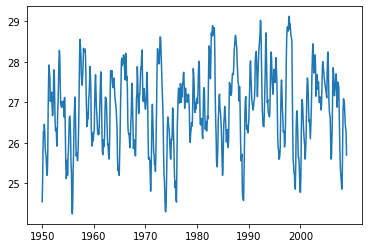

In [31]:
plt.plot(filtered_ts)
plt.xticks(range(0,708+1,12*10),labels=range(1950,2008+1,10))
plt.show()

In [32]:
def get_data(data,years):
    filtered_data = {int(year): data[year] for year in data.keys() if year in years }
    filtered_ts = np.array([])
    filtered_ts = np.array([np.concatenate((filtered_ts,val)) for val in filtered_data.values()]).flatten()
    return filtered_ts

### Train Test Split

In [33]:
train_test_ratio = 0.8
years = np.array(list(filtered_data.keys()))
print('Total years available')
print(years)
print(f'Train Test ratio: {train_test_ratio}')
training_years = years[:int(train_test_ratio*len(years))]
print(f'No of years in training: {len(training_years)}')
print(training_years)
testing_years = years[int(train_test_ratio*len(years)):]
print(f'No of years in testing: {len(testing_years)}')
print(testing_years)

Total years available
[1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008]
Train Test ratio: 0.8
No of years in training: 47
[1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996]
No of years in testing: 12
[1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008]


In [107]:
training_data = get_data(filtered_data,training_years)
training_means = get_data(mean_data_dict,training_years)
test_data = get_data(filtered_data,testing_years)
test_means = get_data(mean_data_dict,testing_years)

In [108]:
len(training_data),len(training_means)

(564, 564)

In [109]:
assert len(training_years)*12 == len(training_data)
assert len(training_years)*12 == len(training_means)

### Scaling data

In [110]:
scaler = StandardScaler()
scaled_training_data = scaler.fit_transform(training_data.reshape(-1, 1))
scaled_training_means = scaler.transform(training_means.reshape(-1, 1))

In [112]:
scaled_test_data = scaler.transform(test_data.reshape(-1, 1))
scaled_test_means = scaler.transform(test_means.reshape(-1, 1))

### Plotting training data, mean, acf and pacf

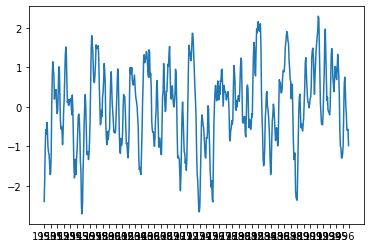

In [40]:
plt.plot(scaled_training_data)
#plt.plot(reqd_means)
plt.xticks(range(0,len(training_data)+1,12),labels=training_years)
plt.show()

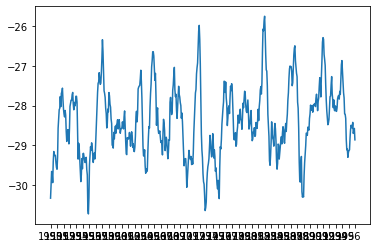

In [42]:
#plt.plot(reqd_data)
plt.plot(scaled_training_means)
plt.xticks(range(0,len(scaled_training_means)+1,12),labels=training_years)
plt.show()

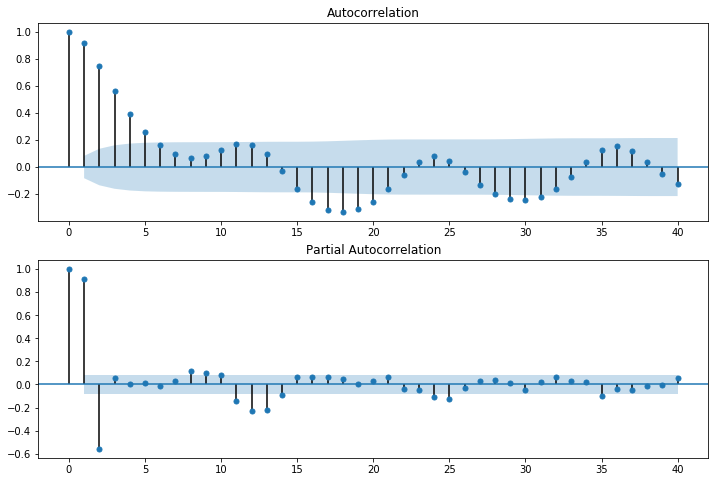

In [43]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(scaled_training_data, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(scaled_training_data, lags=40, ax=ax2)
plt.show()

### Fitting LSTM model

In [83]:
def transform_data(arr, seq_len, lag):
    x, y = [], []
    for i in range(len(arr) - seq_len - lag):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + lag : i + seq_len + lag]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y).reshape(-1, seq_len)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var

In [113]:
seq_len=10
x_train, y_train = transform_data(scaled_training_data,seq_len,6)
x_val, y_val = transform_data(scaled_test_data,seq_len,6)

### Scaling data

In [97]:
len(x_train),len(y_train)

(548, 548)

In [98]:
def plot_sequence(axes, i, x_train, y_train):
    axes[i].set_title("%d. Sequence" % (i + 1))
    axes[i].set_xlabel("Time Bars")
    axes[i].set_ylabel("Scaled VWAP")
    axes[i].plot(range(seq_len), x_train[i].cpu().numpy(), color="r", label="Feature")
    axes[i].plot(range(1,seq_len+1), y_train[i].cpu().numpy(), color="b", label="Target")
    axes[i].legend()

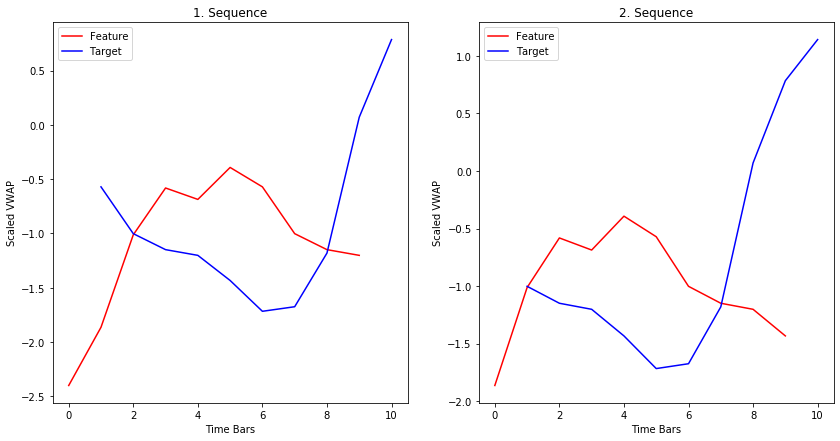

In [99]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
plot_sequence(axes, 0, x_train, y_train)
plot_sequence(axes, 1, x_train, y_train)

In [100]:
import torch.nn as nn
import torch.optim as optim


class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, future=0, y=None):
        outputs = []

        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]

        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [140]:
import time
import random


class Optimization:
    """ A helper class to train, test and diagnose the LSTM"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            yield x_batch, y_batch, batch

    def train(
        self,
        x_train,
        y_train,
        x_val=None,
        y_val=None,
        batch_size=16,
        n_epochs=15,
        do_teacher_forcing=None,
    ):
        seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []

            train_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):               
                y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.scheduler.step()
            train_loss /= batch
            self.train_losses.append(train_loss)

            self._validation(x_val, y_val, batch_size)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )

    def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len) / 2)
            limit = x_batch.size(1) - future
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            future = 0
            y_pred = self.model(x_batch)
        self.futures.append(future)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= batch
            self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                y_pred = (
                    y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                )
                loss = self.loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
            test_loss /= batch
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")

In [141]:
def generate_sequence(scaler, model, x_sample, future=1000):
    """ Generate future values for x_sample with the model """
    y_pred_tensor = model(x_sample, future=future)
    y_pred = y_pred_tensor.cpu().tolist()
    y_pred = scaler.inverse_transform(y_pred)
    return y_pred

In [142]:
def to_dataframe(actual, predicted):
    return pd.DataFrame({"actual": actual, "predicted": predicted})


def inverse_transform(scalar, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df

In [143]:
model_1 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_1 = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=5, gamma=0.1)
optimization_1 = Optimization(model_1, loss_fn_1, optimizer_1, scheduler_1)

In [144]:
optimization_1.train(x_train, y_train, x_val, y_val, do_teacher_forcing=False, n_epochs=5)

Epoch 1 Train loss: 1.04. Validation loss: 1.27. Avg future: 0.00. Elapsed time: 0.13s.
Epoch 2 Train loss: 1.03. Validation loss: 1.24. Avg future: 0.00. Elapsed time: 0.12s.
Epoch 3 Train loss: 1.02. Validation loss: 1.22. Avg future: 0.00. Elapsed time: 0.12s.
Epoch 4 Train loss: 1.01. Validation loss: 1.21. Avg future: 0.00. Elapsed time: 0.12s.
Epoch 5 Train loss: 1.01. Validation loss: 1.21. Avg future: 0.00. Elapsed time: 0.12s.


### Getting predictions for test set

In [147]:
actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(x_val, y_val, future=0, batch_size=16)
df_result_1 = to_dataframe(actual_1, predicted_1) 
df_result_1 = inverse_transform(scaler, df_result_1, ['actual', 'predicted'])

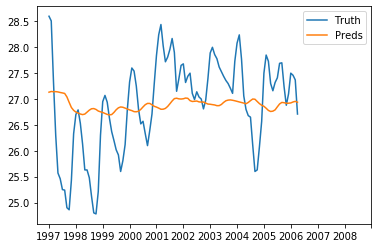

In [148]:
plt.plot(df_result_1.actual,label='Truth')
plt.plot(df_result_1.predicted,label='Preds')
plt.xticks(range(0,len(scaled_test_data)+1,12),labels=testing_years)
plt.legend()
plt.show()

In [149]:
test_mrse = mrse(df_result_1.actual,df_result_1.predicted)
test_re = re(df_result_1.actual,df_result_1.predicted)
print(f'Test MRSE: {test_mrse}\nTest RE: {test_re}')

Test MRSE: 0.9953632968112657
Test RE: 0.03327182800811296


/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  564
Model:                     ARMA(6, 3)   Log Likelihood                     nan
Method:                       css-mle   S.D. of innovations              0.528
Date:                Thu, 14 Nov 2019   AIC                                nan
Time:                        17:34:37   BIC                                nan
Sample:                             0   HQIC                               nan
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.7206        nan        nan        nan         nan         nan
ar.L1.y        2.5767        nan        nan        nan         nan         nan
ar.L2.y       -2.4697        nan        nan        n

/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


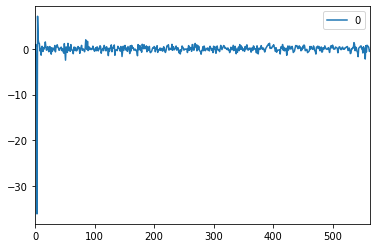

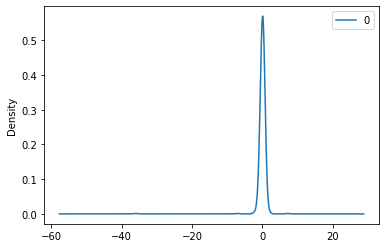

                0
count  564.000000
mean    -0.037935
std      1.672497
min    -36.108667
25%     -0.319342
50%      0.050933
75%      0.389255
max      7.131110


In [31]:
model = ARIMA(training_data, order=(6,0,3))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [ ]:
# model.predict(model_fit.params,start=0,end=-1,dynamic=True)